In [1]:
import os
import json
import skimage
import osmnx as ox
import numpy as np
import pandas as pd
import scipy.spatial
import networkx as nx
import matplotlib.pyplot as plt

### Set config

In [2]:
config_filename = 'demo_config.json'
debug = True

In [3]:
cresi_dir = '/opt/cresi'
%cd {cresi_dir}

/opt/cresi


In [4]:
src_dir = os.path.join(cresi_dir, 'cresi')
config_dir = os.path.join(cresi_dir, src_dir, 'configs')

data_dir  = os.path.join(cresi_dir, 'data')
raw_data_dir = os.path.join(cresi_dir, data_dir, 'raw_data')
clipped_data_dir = os.path.join(cresi_dir, data_dir, 'clipped_data')
eight_bit_dir = os.path.join(cresi_dir, data_dir, '8bit_data')
sliced_dir = os.path.join(cresi_dir, data_dir, 'sliced_data')

results_dir = os.path.join(cresi_dir, 'results')
mask_pred_dir = os.path.join(results_dir, 'folds')
mask_stitched_dir = os.path.join(results_dir, 'stitched/mask_norm')

# make dirs
#for d in [weight_dir, test_im_raw_dir, test_im_clip_dir, test_final_dir, mask_stitched_dir, mask_pred_dir]:
#    os.makedirs(d, exist_ok=True)

In [5]:
config_path = os.path.join(config_dir, config_filename)

# update directories
with open(config_path, 'r+') as f:
    data = json.load(f)
    data['path_src'] = src_dir
    data['path_data_root'] = data_dir
    data['results_dir'] = results_dir
    
    data['clipped_data_dir'] = clipped_data_dir
    data['eight_bit_dir'] = eight_bit_dir
    data['sliced_dir'] = sliced_dir

In [6]:
# write new values
os.remove(config_path)
with open(config_path, 'w') as f:
    json.dump(data, f, indent=4)

### Convert 16bit MS to 8bit, 3 band

In [7]:
#import rasterio 
"""
for im_name in os.listdir(test_im_clip_dir):
    break
    ds = rasterio.open(os.path.join(test_im_clip_dir, im_name))

    n_ds = rasterio.open(
        os.path.join(test_final_dir, im_name),
        'w',
        driver='GTiff',
        height=ds.shape[0],
        width=ds.shape[1],
        count=3, # 3 bands
        dtype='uint8', # 8 bit
        crs=ds.crs, # copy from orig
        transform=ds.transform # lonlat bounds, copy from orig
    )
    
    # 3 band orig
    if len(ds.dtypes) == 3:
        n_ds.write_band(1, ds.read(1).astype('uint8'))
        n_ds.write_band(2, ds.read(2).astype('uint8'))
        n_ds.write_band(3, ds.read(3).astype('uint8'))
    elif len(ds.dtypes) == 8:
        n_ds.write_band(1, ds.read(5).astype('uint8'))
        n_ds.write_band(2, ds.read(3).astype('uint8'))
        n_ds.write_band(3, ds.read(2).astype('uint8'))
    else:
        print ('Unknown source type.')
    
    n_ds.close()
"""
 

"\nfor im_name in os.listdir(test_im_clip_dir):\n    break\n    ds = rasterio.open(os.path.join(test_im_clip_dir, im_name))\n\n    n_ds = rasterio.open(\n        os.path.join(test_final_dir, im_name),\n        'w',\n        driver='GTiff',\n        height=ds.shape[0],\n        width=ds.shape[1],\n        count=3, # 3 bands\n        dtype='uint8', # 8 bit\n        crs=ds.crs, # copy from orig\n        transform=ds.transform # lonlat bounds, copy from orig\n    )\n    \n    # 3 band orig\n    if len(ds.dtypes) == 3:\n        n_ds.write_band(1, ds.read(1).astype('uint8'))\n        n_ds.write_band(2, ds.read(2).astype('uint8'))\n        n_ds.write_band(3, ds.read(3).astype('uint8'))\n    elif len(ds.dtypes) == 8:\n        n_ds.write_band(1, ds.read(5).astype('uint8'))\n        n_ds.write_band(2, ds.read(3).astype('uint8'))\n        n_ds.write_band(3, ds.read(2).astype('uint8'))\n    else:\n        print ('Unknown source type.')\n    \n    n_ds.close()\n"

In [8]:
im_name = [z for z in os.listdir(raw_data_dir) if z.endswith('.tif')][0]
print("im_name:", im_name)

test_im_raw = os.path.join(raw_data_dir, im_name)
test_im_tmp = os.path.join(clipped_data_dir, im_name.split('.tif')[0] + '_clip.vrt')
print("temp file:", test_im_tmp)

test_im_clip = os.path.join(clipped_data_dir, im_name.split('.tif')[0] + '_clip_60cm.tif')
print("output_file:", test_im_clip)

im_name: 000-001-RGB.tif
temp file: /opt/cresi/data/clipped_data/000-001-RGB_clip.vrt
output_file: /opt/cresi/data/clipped_data/000-001-RGB_clip_60cm.tif


In [9]:
# trim to latlong bounds
#ulx, uly, lrx, lry = 39.25252, -6.7580, 39.28430, -6.7880  # v0
#!gdal_translate -projwin {ulx} {uly} {lrx} {lry} {test_im_raw} {test_im_tmp}

In [10]:
# resample 30 cm imagery to 60 cm
#!gdal_translate -outsize 50% 50% {test_im_tmp} {test_im_clip}

In [11]:
# this works much better, but we can't use gdal 
from cresi import create_8bit_images

# Convert 16-bit multispectral test data to 8-bit RGB
create_8bit_images.dir_to_8bit(raw_data_dir, eight_bit_dir,
                              command_file_loc='',
                              rescale_type="perc",
                              percentiles=[2,98],
                              band_order=[]) # specify [5,3,2] if MS channels. Here we are using RGB itself

im_files: ['000-001-RGB.tif']
Input file size is 5057, 5057
0...10...20...30...40...50...60...70...80...90...100 - done.


In [12]:
# display our image
#im_name = [z for z in os.listdir(eight_bit_dir) if z.endswith('.tif')][0]
#im_path = os.path.join(eight_bit_dir, im_name)
#im = skimage.io.imread(im_path)

#skimage.io.imshow(im) 
#skimage.io.show()

### Slice image into processable chunks
slice_x, slice_y defined in config

In [13]:
%run -i cresi/01_slice.py { config_path }

Executing tile_im.py..
slice command: python /opt/cresi/cresi/data_prep/tile_im.py /opt/cresi/cresi/configs/demo_config.json
Output path for sliced images: /opt/cresi/data/sliced_data
processing starting
Slicing /opt/cresi/data/8bit_data
im_path /opt/cresi/data/8bit_data/000-001-RGB.tif
im.shape: (5057, 5057, 3)
n pixels: 25573249
  len df; 16
  Time to slice arrays: 4.893352270126343 seconds
  Total pixels in test image(s): 25573249
df saved to file: /opt/cresi/results/tile_df.csv


### Run Inference

In [14]:
%run -i cresi/02_eval.py { config_path }

save_dir: /opt/cresi/results/folds
paths: {'masks': '', 'images': '/opt/cresi/data/sliced_data'}
fn_mapping: {'masks': <function <lambda> at 0x7fb109dd3af0>}
image_suffix: 
num_workers: 0
fold: 0
run eval.Evaluator.predict()...
prefix: 
Creating datasets within pytorch_utils/eval.py()...
val_indexes:[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
len val_dl: 144
self.num_workers 4
Running eval.read_model()...
load model with cpu
  model sucessfully loaded


  0%|                                                                                                                               | 0/144 [00:00<?, ?it/s]

  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


  1%|▊                                                                                                                      | 1/144 [00:02<06:03,  2.54s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


  1%|█▋                                                                                                                     | 2/144 [00:04<05:36,  2.37s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


  2%|██▍                                                                                                                    | 3/144 [00:06<05:15,  2.24s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


  3%|███▎                                                                                                                   | 4/144 [00:09<05:10,  2.22s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


  3%|████▏                                                                                                                  | 5/144 [00:11<05:04,  2.19s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


  4%|████▉                                                                                                                  | 6/144 [00:13<05:14,  2.28s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


  5%|█████▊                                                                                                                 | 7/144 [00:15<05:12,  2.28s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


  6%|██████▌                                                                                                                | 8/144 [00:18<05:07,  2.26s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


  6%|███████▍                                                                                                               | 9/144 [00:20<05:03,  2.25s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


  7%|████████▏                                                                                                             | 10/144 [00:22<04:58,  2.23s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


  8%|█████████                                                                                                             | 11/144 [00:24<04:55,  2.22s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


  8%|█████████▊                                                                                                            | 12/144 [00:26<04:48,  2.19s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


  9%|██████████▋                                                                                                           | 13/144 [00:29<04:49,  2.21s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 10%|███████████▍                                                                                                          | 14/144 [00:31<04:41,  2.17s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 10%|████████████▎                                                                                                         | 15/144 [00:33<04:41,  2.18s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 11%|█████████████                                                                                                         | 16/144 [00:35<04:39,  2.18s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 12%|█████████████▉                                                                                                        | 17/144 [00:37<04:39,  2.20s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 12%|██████████████▊                                                                                                       | 18/144 [00:40<04:40,  2.22s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 13%|███████████████▌                                                                                                      | 19/144 [00:42<04:42,  2.26s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 14%|████████████████▍                                                                                                     | 20/144 [00:44<04:37,  2.24s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 15%|█████████████████▏                                                                                                    | 21/144 [00:46<04:34,  2.23s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 15%|██████████████████                                                                                                    | 22/144 [00:49<04:31,  2.23s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 16%|██████████████████▊                                                                                                   | 23/144 [00:51<04:28,  2.22s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 17%|███████████████████▋                                                                                                  | 24/144 [00:53<04:28,  2.24s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 17%|████████████████████▍                                                                                                 | 25/144 [00:55<04:22,  2.21s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 18%|█████████████████████▎                                                                                                | 26/144 [00:57<04:20,  2.21s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 19%|██████████████████████▏                                                                                               | 27/144 [01:00<04:19,  2.22s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 19%|██████████████████████▉                                                                                               | 28/144 [01:02<04:15,  2.20s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 20%|███████████████████████▊                                                                                              | 29/144 [01:04<04:13,  2.20s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 21%|████████████████████████▌                                                                                             | 30/144 [01:06<04:08,  2.18s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 22%|█████████████████████████▍                                                                                            | 31/144 [01:08<04:05,  2.17s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 22%|██████████████████████████▏                                                                                           | 32/144 [01:10<04:03,  2.17s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 23%|███████████████████████████                                                                                           | 33/144 [01:13<04:02,  2.18s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 24%|███████████████████████████▊                                                                                          | 34/144 [01:15<03:58,  2.17s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 24%|████████████████████████████▋                                                                                         | 35/144 [01:17<04:02,  2.22s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 25%|█████████████████████████████▌                                                                                        | 36/144 [01:19<04:01,  2.24s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 26%|██████████████████████████████▎                                                                                       | 37/144 [01:22<04:00,  2.25s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 26%|███████████████████████████████▏                                                                                      | 38/144 [01:24<03:59,  2.26s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 27%|███████████████████████████████▉                                                                                      | 39/144 [01:26<03:55,  2.24s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 28%|████████████████████████████████▊                                                                                     | 40/144 [01:28<03:48,  2.20s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 28%|█████████████████████████████████▌                                                                                    | 41/144 [01:30<03:45,  2.18s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 29%|██████████████████████████████████▍                                                                                   | 42/144 [01:33<03:45,  2.21s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 30%|███████████████████████████████████▏                                                                                  | 43/144 [01:35<03:42,  2.20s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 31%|████████████████████████████████████                                                                                  | 44/144 [01:37<03:40,  2.20s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 31%|████████████████████████████████████▉                                                                                 | 45/144 [01:39<03:35,  2.18s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 32%|█████████████████████████████████████▋                                                                                | 46/144 [01:42<03:38,  2.23s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 33%|██████████████████████████████████████▌                                                                               | 47/144 [01:44<03:38,  2.25s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 33%|███████████████████████████████████████▎                                                                              | 48/144 [01:46<03:35,  2.25s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 34%|████████████████████████████████████████▏                                                                             | 49/144 [01:48<03:33,  2.25s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 35%|████████████████████████████████████████▉                                                                             | 50/144 [01:51<03:28,  2.22s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 35%|█████████████████████████████████████████▊                                                                            | 51/144 [01:53<03:25,  2.21s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 36%|██████████████████████████████████████████▌                                                                           | 52/144 [01:55<03:22,  2.21s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 37%|███████████████████████████████████████████▍                                                                          | 53/144 [01:57<03:20,  2.20s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 38%|████████████████████████████████████████████▎                                                                         | 54/144 [01:59<03:19,  2.21s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 38%|█████████████████████████████████████████████                                                                         | 55/144 [02:01<03:14,  2.19s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 39%|█████████████████████████████████████████████▉                                                                        | 56/144 [02:04<03:12,  2.19s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 40%|██████████████████████████████████████████████▋                                                                       | 57/144 [02:06<03:09,  2.18s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 40%|███████████████████████████████████████████████▌                                                                      | 58/144 [02:08<03:08,  2.19s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 41%|████████████████████████████████████████████████▎                                                                     | 59/144 [02:10<03:07,  2.21s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 42%|█████████████████████████████████████████████████▏                                                                    | 60/144 [02:12<03:03,  2.18s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 42%|█████████████████████████████████████████████████▉                                                                    | 61/144 [02:15<03:00,  2.18s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 43%|██████████████████████████████████████████████████▊                                                                   | 62/144 [02:17<02:58,  2.18s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 44%|███████████████████████████████████████████████████▋                                                                  | 63/144 [02:19<02:58,  2.21s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 44%|████████████████████████████████████████████████████▍                                                                 | 64/144 [02:21<02:58,  2.23s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 45%|█████████████████████████████████████████████████████▎                                                                | 65/144 [02:24<02:57,  2.25s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 46%|██████████████████████████████████████████████████████                                                                | 66/144 [02:26<02:55,  2.25s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 47%|██████████████████████████████████████████████████████▉                                                               | 67/144 [02:28<02:52,  2.24s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 47%|███████████████████████████████████████████████████████▋                                                              | 68/144 [02:30<02:49,  2.23s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 48%|████████████████████████████████████████████████████████▌                                                             | 69/144 [02:32<02:47,  2.23s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 49%|█████████████████████████████████████████████████████████▎                                                            | 70/144 [02:35<02:45,  2.23s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 49%|██████████████████████████████████████████████████████████▏                                                           | 71/144 [02:37<02:52,  2.37s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 50%|███████████████████████████████████████████████████████████                                                           | 72/144 [02:40<02:48,  2.34s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 51%|███████████████████████████████████████████████████████████▊                                                          | 73/144 [02:42<02:43,  2.30s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 51%|████████████████████████████████████████████████████████████▋                                                         | 74/144 [02:44<02:40,  2.29s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 52%|█████████████████████████████████████████████████████████████▍                                                        | 75/144 [02:46<02:35,  2.26s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 53%|██████████████████████████████████████████████████████████████▎                                                       | 76/144 [02:49<02:33,  2.26s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 53%|███████████████████████████████████████████████████████████████                                                       | 77/144 [02:51<02:30,  2.25s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 54%|███████████████████████████████████████████████████████████████▉                                                      | 78/144 [02:53<02:27,  2.24s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 55%|████████████████████████████████████████████████████████████████▋                                                     | 79/144 [02:55<02:26,  2.25s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 56%|█████████████████████████████████████████████████████████████████▌                                                    | 80/144 [02:57<02:22,  2.22s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 56%|██████████████████████████████████████████████████████████████████▍                                                   | 81/144 [03:00<02:21,  2.25s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 57%|███████████████████████████████████████████████████████████████████▏                                                  | 82/144 [03:02<02:19,  2.26s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 58%|████████████████████████████████████████████████████████████████████                                                  | 83/144 [03:05<02:21,  2.32s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 58%|████████████████████████████████████████████████████████████████████▊                                                 | 84/144 [03:07<02:20,  2.34s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 59%|█████████████████████████████████████████████████████████████████████▋                                                | 85/144 [03:09<02:18,  2.36s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 60%|██████████████████████████████████████████████████████████████████████▍                                               | 86/144 [03:12<02:14,  2.33s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 60%|███████████████████████████████████████████████████████████████████████▎                                              | 87/144 [03:14<02:11,  2.30s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 61%|████████████████████████████████████████████████████████████████████████                                              | 88/144 [03:16<02:07,  2.28s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 62%|████████████████████████████████████████████████████████████████████████▉                                             | 89/144 [03:18<02:04,  2.27s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 62%|█████████████████████████████████████████████████████████████████████████▊                                            | 90/144 [03:21<02:03,  2.28s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 63%|██████████████████████████████████████████████████████████████████████████▌                                           | 91/144 [03:23<02:00,  2.27s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 64%|███████████████████████████████████████████████████████████████████████████▍                                          | 92/144 [03:25<01:57,  2.25s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 65%|████████████████████████████████████████████████████████████████████████████▏                                         | 93/144 [03:27<01:54,  2.24s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 65%|█████████████████████████████████████████████████████████████████████████████                                         | 94/144 [03:29<01:51,  2.23s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 66%|█████████████████████████████████████████████████████████████████████████████▊                                        | 95/144 [03:32<01:49,  2.22s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 67%|██████████████████████████████████████████████████████████████████████████████▋                                       | 96/144 [03:34<01:47,  2.23s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 67%|███████████████████████████████████████████████████████████████████████████████▍                                      | 97/144 [03:36<01:45,  2.25s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 68%|████████████████████████████████████████████████████████████████████████████████▎                                     | 98/144 [03:38<01:41,  2.21s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 69%|█████████████████████████████████████████████████████████████████████████████████▏                                    | 99/144 [03:41<01:39,  2.21s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 69%|█████████████████████████████████████████████████████████████████████████████████▎                                   | 100/144 [03:43<01:36,  2.20s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 70%|██████████████████████████████████████████████████████████████████████████████████                                   | 101/144 [03:45<01:34,  2.20s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 71%|██████████████████████████████████████████████████████████████████████████████████▉                                  | 102/144 [03:47<01:32,  2.21s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 72%|███████████████████████████████████████████████████████████████████████████████████▋                                 | 103/144 [03:49<01:30,  2.20s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 72%|████████████████████████████████████████████████████████████████████████████████████▌                                | 104/144 [03:52<01:28,  2.21s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 73%|█████████████████████████████████████████████████████████████████████████████████████▎                               | 105/144 [03:54<01:25,  2.20s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 74%|██████████████████████████████████████████████████████████████████████████████████████▏                              | 106/144 [03:56<01:24,  2.23s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 74%|██████████████████████████████████████████████████████████████████████████████████████▉                              | 107/144 [03:58<01:22,  2.22s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 75%|███████████████████████████████████████████████████████████████████████████████████████▊                             | 108/144 [04:01<01:20,  2.24s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 76%|████████████████████████████████████████████████████████████████████████████████████████▌                            | 109/144 [04:03<01:17,  2.21s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 76%|█████████████████████████████████████████████████████████████████████████████████████████▍                           | 110/144 [04:05<01:15,  2.23s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 77%|██████████████████████████████████████████████████████████████████████████████████████████▏                          | 111/144 [04:07<01:13,  2.23s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 78%|███████████████████████████████████████████████████████████████████████████████████████████                          | 112/144 [04:09<01:11,  2.24s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 78%|███████████████████████████████████████████████████████████████████████████████████████████▊                         | 113/144 [04:12<01:09,  2.24s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 79%|████████████████████████████████████████████████████████████████████████████████████████████▋                        | 114/144 [04:14<01:06,  2.23s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 80%|█████████████████████████████████████████████████████████████████████████████████████████████▍                       | 115/144 [04:16<01:04,  2.21s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 81%|██████████████████████████████████████████████████████████████████████████████████████████████▎                      | 116/144 [04:18<01:01,  2.19s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 81%|███████████████████████████████████████████████████████████████████████████████████████████████                      | 117/144 [04:20<00:59,  2.21s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 82%|███████████████████████████████████████████████████████████████████████████████████████████████▉                     | 118/144 [04:23<00:57,  2.20s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 83%|████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 119/144 [04:25<00:55,  2.21s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 120/144 [04:27<00:52,  2.20s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 121/144 [04:29<00:50,  2.21s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 122/144 [04:31<00:48,  2.21s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 123/144 [04:34<00:46,  2.22s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 124/144 [04:36<00:44,  2.22s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 125/144 [04:38<00:42,  2.24s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 126/144 [04:40<00:40,  2.23s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 127/144 [04:43<00:38,  2.25s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████             | 128/144 [04:45<00:35,  2.24s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 129/144 [04:47<00:33,  2.21s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 130/144 [04:49<00:31,  2.22s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 131/144 [04:52<00:28,  2.22s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 132/144 [04:54<00:26,  2.22s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 133/144 [04:56<00:24,  2.23s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 134/144 [04:58<00:22,  2.22s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 135/144 [05:00<00:19,  2.22s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 136/144 [05:03<00:17,  2.20s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 137/144 [05:05<00:15,  2.21s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 138/144 [05:07<00:13,  2.19s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 139/144 [05:09<00:10,  2.19s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 140/144 [05:11<00:08,  2.20s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 141/144 [05:14<00:06,  2.20s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 142/144 [05:16<00:04,  2.21s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 143/144 [05:18<00:02,  2.21s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 512, 512])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 512, 512])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [05:20<00:00,  2.23s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 512, 512, 8)
Time to run 1 folds for 16 = 322.2066354751587 seconds


### Evaluate results

The 02_eval.py script produce a multi-channel road masks for each image tile.  Each channel of this mask corresponds to a unique speed range.  For each of the testing tiles, the predicted mask will look something like the plot below.

mask_pred.shape: (8, 468, 468)


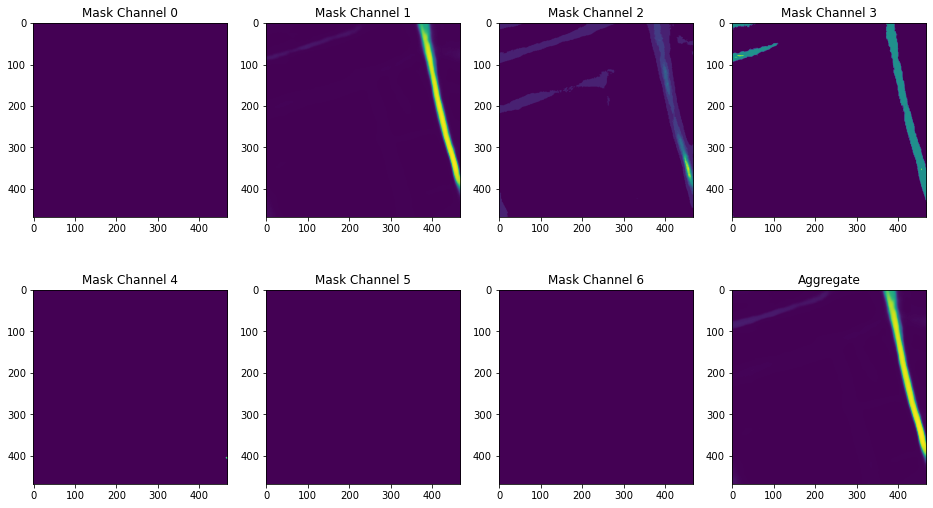

In [15]:
mask_pred_file = [z for z in os.listdir(mask_pred_dir) if z.endswith('.tif')][0]
mask_pred_path = os.path.join(mask_pred_dir, mask_pred_file)
mask_pred = skimage.io.imread(mask_pred_path)
print("mask_pred.shape:", mask_pred.shape)

# plot all layers
fig, axes = plt.subplots(2, 4, figsize=(16, 9))
for i, ax in enumerate(axes.flatten()):
    if i < (len(axes.flatten()) - 1):
        title = 'Mask Channel {}'.format(str(i))
    else:
        title = 'Aggregate' 
    ax.imshow(mask_pred[i,:,:])
    ax.set_title(title)

### Stitch slices back together

In [16]:
%run -i cresi/03_stitch.py { config_path }

Running stitch.py...
num_folds 1
prefix:  
post_process_image - w, h: 5057 5057
0 / 16


ValueError: operands could not be broadcast together with shapes (1300,1300,8) (468,468,8) (1300,1300,8) 

In [17]:
# Inspect the output
plot_all_layers = False
mask_pred_file = [z for z in os.listdir(mask_stitched_dir) if z.endswith('.tif')][0]
mask_pred_path = os.path.join(mask_stitched_dir, mask_pred_file)
mask_pred = skimage.io.imread(mask_pred_path)# + '.2.tif')
print("mask_pred.shape:", mask_pred.shape)

# plot final layer
fig_width, fig_height = 12, 12
fig, ax = plt.subplots(figsize=(fig_width, fig_height))
_ = ax.imshow(mask_pred[-1,:,:])
_ = ax.set_title('Aggregate - ' + mask_pred_file)

# plot all layers (optional)
if plot_all_layers:
    fig, axes = plt.subplots(2, 4, figsize=(20, 11))
    for i, ax in enumerate(axes.flatten()):
        if i < (len(axes.flatten()) - 1):
            title = 'Mask Channel {}'.format(str(i))
        else:
            title = 'Aggregate' 
        ax.imshow(mask_pred[i,:,:])
        ax.set_title(title)

IndexError: list index out of range

-----
The 04_skeletonize script creates a graph from the aggregate mask via a multi-step process:
    
1. Refine aggregate mask via smoothing, openings, and closings.

2. Extract a skeleton of the refined mask.

3. Build a graph from the skeleton.  

4. Clean out spurious edges and complete missing connections.

5. Output a csv of graph edges.  This csv output is included as a convenient intermediate step, since if speeds and geographic coordinates are not required we can forego Sections 5.4 and 5.5.

The 04_skeletonize.py script is multi-threaded to improve speed

In [ ]:
%run -i cresi/04_skeletonize.py { config_path }

In [ ]:
# inspect the output
csv_path = os.path.join(results_dir, 'wkt_submission_nospeed.csv')
df = pd.read_csv(csv_path)
df.head()

-----
### 5.4. 05_wkt_to_G.py

This script reads the csv output by 04_skeletonize.py back into graph format (which is very quick), and then uses the metadata encoded in our geotiff test image to assign geographic coordinates to the graph.  Assigning geo-coordinates for thousands of nodes is a computationally intensive process, so this script is multi-threaded to improve performance. The script outputs a [NetworkX](https://networkx.github.io) graph structure in ~60 seconds.

In [ ]:
%run -i cresi/05_wkt_to_G.py { config_path }

In [ ]:
# inspect the output
gpickle_file = [z for z in os.listdir(os.path.join(results_dir, 'graphs')) if z.endswith('.gpickle')][0]
gpickle_path = os.path.join(results_dir, 'graphs', gpickle_file)
G0 = nx.read_gpickle(gpickle_path)
_, _ = ox.plot_graph(G0, figsize=(12,12))